In [48]:
import torch

import numpy as np

from sbi.analysis import pairplot
from sbi.inference import NPE,NLE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from torch.distributions import Normal, Independent,InverseGamma

In [49]:
num_dim = 2  # 这里的 num_dim = 2，表示我们有两个参数 μ 和 σ

# 定义模拟器函数
# torch.randn：生成一个服从标准正态分布（即均值为 0，标准差为 1）的随机数。
def simulator(theta, n=1000):
    # theta[0] 是 μ, theta[1] 是 σ
    mu, sigma = theta[0], theta[1]
    return mu + np.sqrt(sigma) * torch.randn(n)  # 生成 n 组观测数据


#torch.ones(num_dim)是参数的维度

# prior = BoxUniform(low= -2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
#必须是torch.distributions 因为需要sample
prior = [Normal(torch.tensor([0.0]), torch.tensor([1.0])),InverseGamma(torch.tensor([2.0]), torch.tensor([1.0]))]


In [50]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)
# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)


/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_60648/3563422826.py:1: UserWarning: Prior was provided as a sequence of 2 priors. They will be interpreted as independent of each other and matched in order to the components of the parameter.
  prior, num_parameters, prior_returns_numpy = process_prior(prior)


In [51]:
inference = NLE(prior=prior)

# 生成模拟数据
num_simulations = 500
theta = prior.sample((num_simulations,))
x = simulator(theta)

# 打印检查
print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([500, 2])
x.shape torch.Size([500, 1000])


In [52]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 242 epochs.

In [53]:
posterior = inference.build_posterior(density_estimator)
theta_true = torch.tensor([[0,0.3]]) 
x_obs = simulator(theta_true)
samples = posterior.sample((10000,), x=x_obs)

/opt/anaconda3/envs/SBI_project/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

In [54]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差
alpha_0 = 2
beta_0 = 1  # 先验比例参数

# 数据准备
Z = x_obs.numpy()  # 如果是 PyTorch 张量，转换为 NumPy 数组
Z_flat = Z.flatten()  # 展平成一维数组

# 样本均值和样本数量
Y_mean = np.mean(Z_flat)  # 样本均值
n = Z.size  # 样本数量

# 计算样本总方差
variance = np.sum((Z_flat - Y_mean) ** 2)  # 总变异

kappa_0 = 1
kappa_n = kappa_0 + n

# 后验参数计算
# sigma^2 的后验
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)


# mu 的后验
sigma_poster_sq = sigma_0_sq / (kappa_0+n)  # 后验方差
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # 后验均值

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 502.0
Posterior beta: 141.85585065307222
Posterior mu (mean): -0.0009304974330486832
Posterior sigma^2 (variance): 0.000999000999000999


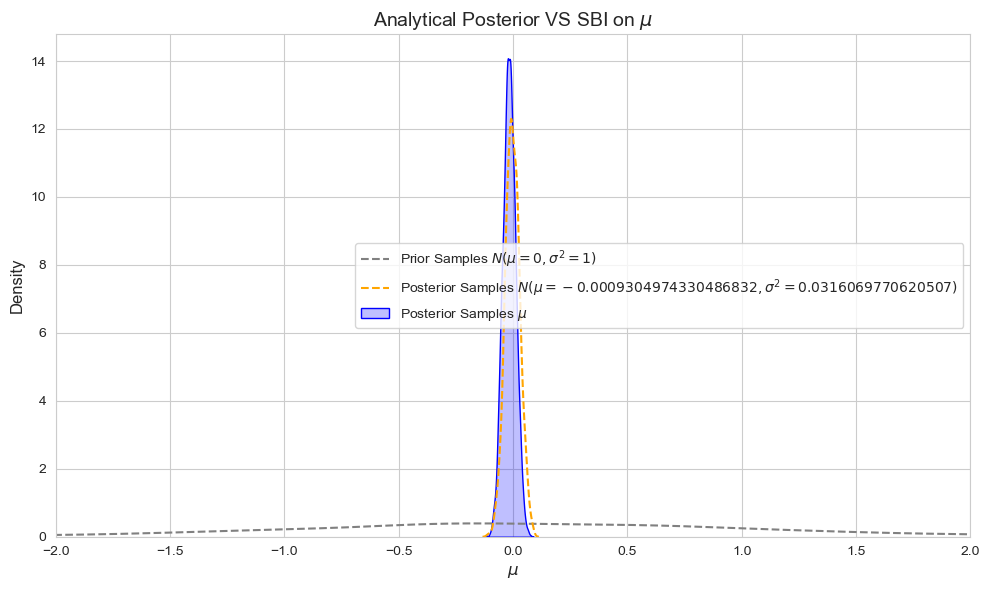

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 mu_samples 和 theta_true 已经定义
# 从样本中提取 mu_samples

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
theta_true = theta_true.numpy() if torch.is_tensor(theta_true) else theta_true
num_samples = 1000  # 样本数量

# 设置 Prior 分布的参数
mu_prior = 0  # 均值
sigma_prior = 1  # 标准差

# 从 Prior 分布生成样本
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, label=f"Prior Samples $N(\mu={mu_prior}, \sigma^2={sigma_prior})$", color="grey",linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# 从 Prior 分布生成样本
prior_samples = np.random.normal(loc=mu_poster, scale=sigma_poster, size=num_samples)

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, label=f"Posterior Samples $N(\mu={mu_poster}, \sigma^2={sigma_poster})$", color="orange",linestyle="--")


# 使用采样数据绘制 Posterior 的 KDE 图
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# theta_true_value 如果需要可以绘制
theta_true_value = theta_true[0, 0].item()

# 添加图例、标题和标签
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\mu$ = {theta_true_value}")
ax.set_title("Analytical Posterior VS SBI on $\mu$", fontsize=14)
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(-2, 2)

# 显示图形
plt.tight_layout()
plt.show()


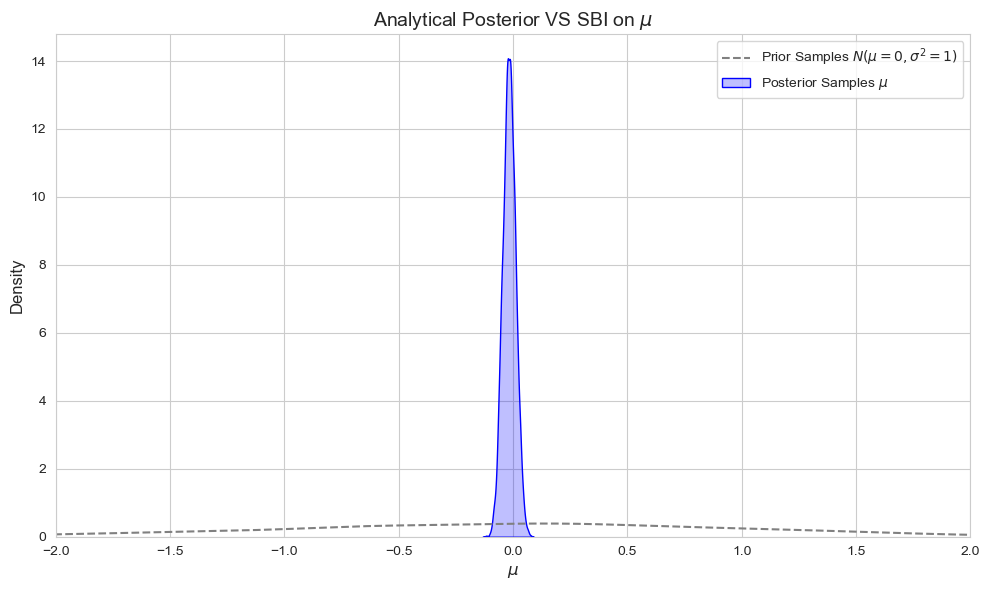

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 mu_samples 和 theta_true 已经定义
# 从样本中提取 mu_samples

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
theta_true = theta_true.numpy() if torch.is_tensor(theta_true) else theta_true
num_samples = 1000  # 样本数量

# 设置 Prior 分布的参数
mu_prior = 0  # 均值
sigma_prior = 1  # 标准差

# 从 Prior 分布生成样本
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, label=f"Prior Samples $N(\mu={mu_prior}, \sigma^2={sigma_prior})$", color="grey",linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)


# 使用采样数据绘制 Posterior 的 KDE 图
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# theta_true_value 如果需要可以绘制
theta_true_value = theta_true[0, 0].item()

# 添加图例、标题和标签
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\mu$ = {theta_true_value}")
ax.set_title("Analytical Posterior VS SBI on $\mu$", fontsize=14)
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(-2, 2)

# 显示图形
plt.tight_layout()
plt.show()


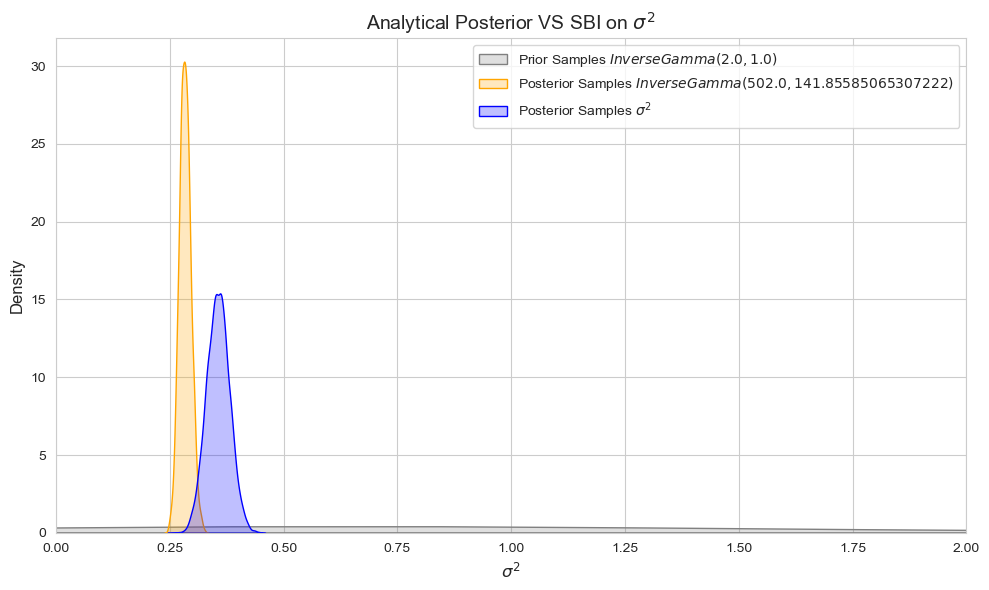

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 从样本中提取第二个维度的值
sigma2_samples = samples[:, 1].numpy()  # 提取样本的第二个维度（例如 $\sigma^2$）
theta_true_value = theta_true[0, 1].item() if torch.is_tensor(theta_true) else theta_true[0, 1]

num_samples = 1000  # 样本数量

# 设置 Prior 分布的参数
alpha_prior = 2.0  # 形状参数 α
beta_prior = 1.0   # 率参数 β

# 转换为逆伽马分布样本
prior_samples = 1 / np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=num_samples)  

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, fill=True, label=f"Prior Samples $InverseGamma({alpha_prior}, {beta_prior})$", color="grey")

# 转换为逆伽马分布样本
prior_samples = 1 / np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=num_samples)  

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, fill=True, label=f"Posterior Samples $InverseGamma({alpha_poster}, {beta_poster})$", color="orange")


# 使用采样数据绘制 Posterior 的 KDE 图
sns.kdeplot(sigma2_samples, ax=ax, fill=True, label=r"Posterior Samples $\sigma^2$", color="blue")

# 如果需要，可以添加真实值的垂直线
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\sigma^2$ = {theta_true_value}")

# 添加图例、标题和标签
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(0, 2)

# 显示图形
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 创建绘图

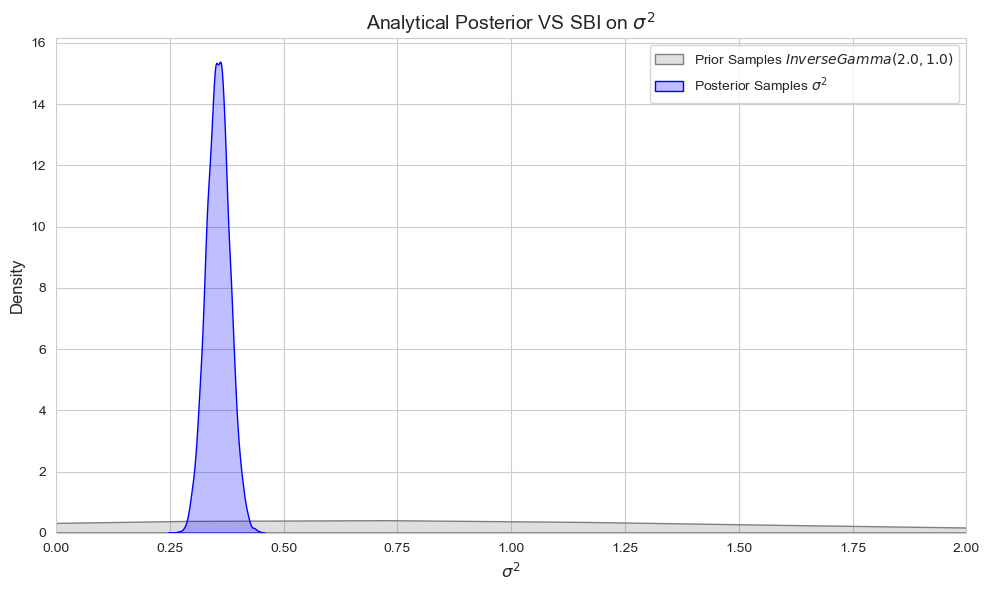

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

# 从样本中提取第二个维度的值
sigma2_samples = samples[:, 1].numpy()  # 提取样本的第二个维度（例如 $\sigma^2$）
theta_true_value = theta_true[0, 1].item() if torch.is_tensor(theta_true) else theta_true[0, 1]

num_samples = 1000  # 样本数量

# 设置 Prior 分布的参数
alpha_prior = 2.0  # 形状参数 α
beta_prior = 1.0   # 率参数 β

# 转换为逆伽马分布样本
prior_samples = 1 / np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=num_samples)  

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, fill=True, label=f"Prior Samples $InverseGamma({alpha_prior}, {beta_prior})$", color="grey")


# 使用采样数据绘制 Posterior 的 KDE 图
sns.kdeplot(sigma2_samples, ax=ax, fill=True, label=r"Posterior Samples $\sigma^2$", color="blue")

# 如果需要，可以添加真实值的垂直线
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\sigma^2$ = {theta_true_value}")

# 添加图例、标题和标签
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(0, 2)

# 显示图形
plt.tight_layout()
plt.show()


In [59]:
posterior = inference.build_posterior(density_estimator)
theta_true = torch.tensor([[-0.3,1]]) 
x_obs = simulator(theta_true)
samples = posterior.sample((10000,), x=x_obs)

/opt/anaconda3/envs/SBI_project/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

In [60]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差
alpha_0 = 2
beta_0 = 1  # 先验比例参数

# 数据准备
Z = x_obs.numpy()  # 如果是 PyTorch 张量，转换为 NumPy 数组
Z_flat = Z.flatten()  # 展平成一维数组

# 样本均值和样本数量
Y_mean = np.mean(Z_flat)  # 样本均值
n = Z.size  # 样本数量

# 计算样本总方差
variance = np.sum((Z_flat - Y_mean) ** 2)  # 总变异

kappa_0 = 1
kappa_n = kappa_0 + n

# 后验参数计算
# sigma^2 的后验
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)


# mu 的后验
sigma_poster_sq = sigma_0_sq / (kappa_0+n)  # 后验方差
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # 后验均值

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 502.0
Posterior beta: 518.5867826070529
Posterior mu (mean): -0.32904619103545074
Posterior sigma^2 (variance): 0.000999000999000999


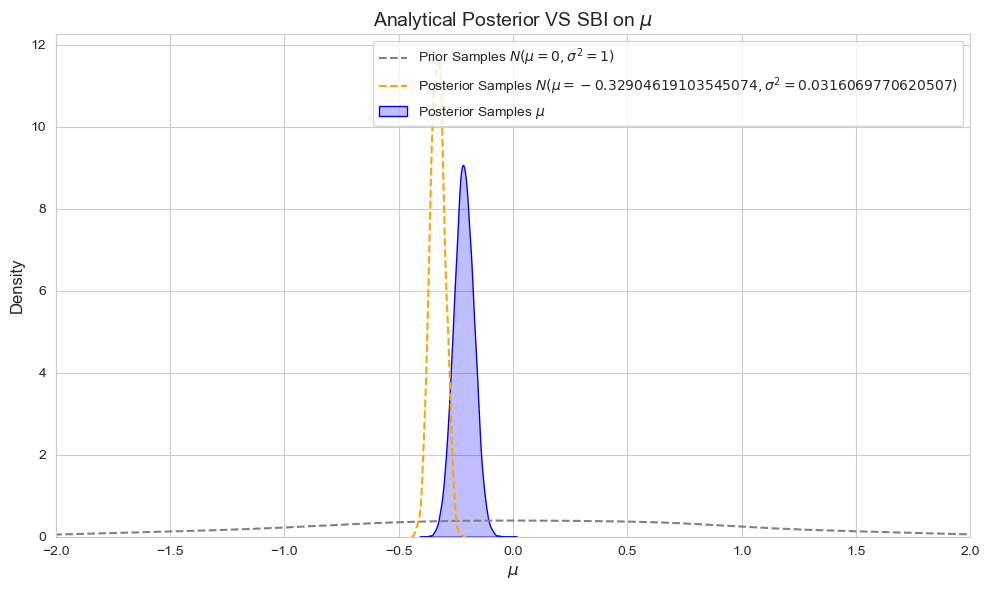

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 mu_samples 和 theta_true 已经定义
# 从样本中提取 mu_samples

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
theta_true = theta_true.numpy() if torch.is_tensor(theta_true) else theta_true
num_samples = 1000  # 样本数量

# 设置 Prior 分布的参数
mu_prior = 0  # 均值
sigma_prior = 1  # 标准差

# 从 Prior 分布生成样本
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, label=f"Prior Samples $N(\mu={mu_prior}, \sigma^2={sigma_prior})$", color="grey",linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# 从 Prior 分布生成样本
prior_samples = np.random.normal(loc=mu_poster, scale=sigma_poster, size=num_samples)

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, label=f"Posterior Samples $N(\mu={mu_poster}, \sigma^2={sigma_poster})$", color="orange",linestyle="--")


# 使用采样数据绘制 Posterior 的 KDE 图
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# theta_true_value 如果需要可以绘制
theta_true_value = theta_true[0, 0].item()

# 添加图例、标题和标签
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\mu$ = {theta_true_value}")
ax.set_title("Analytical Posterior VS SBI on $\mu$", fontsize=14)
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(-2, 2)

# 显示图形
plt.tight_layout()
plt.show()


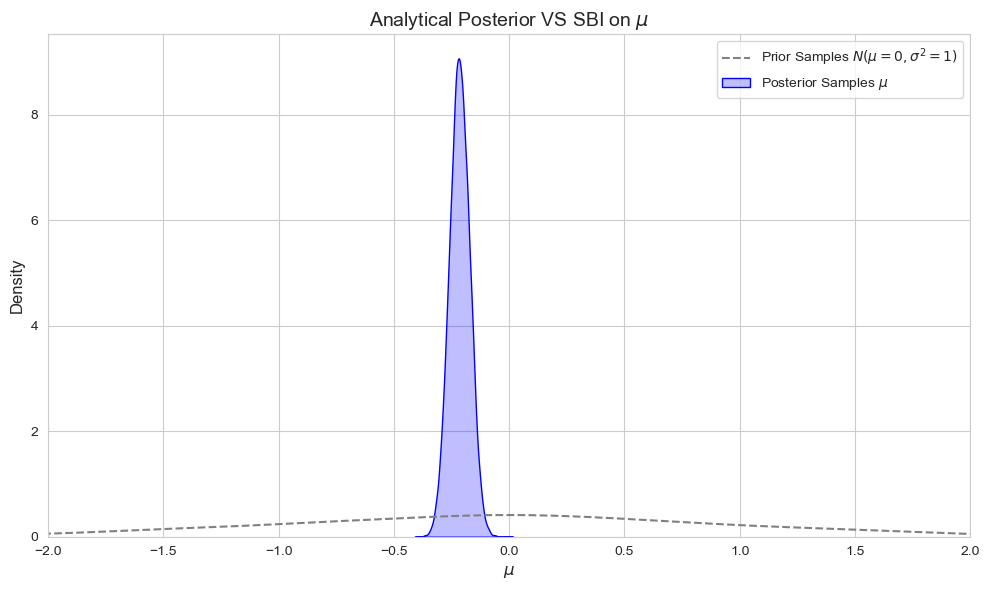

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 mu_samples 和 theta_true 已经定义
# 从样本中提取 mu_samples

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
theta_true = theta_true.numpy() if torch.is_tensor(theta_true) else theta_true
num_samples = 1000  # 样本数量

# 设置 Prior 分布的参数
mu_prior = 0  # 均值
sigma_prior = 1  # 标准差

# 从 Prior 分布生成样本
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax, label=f"Prior Samples $N(\mu={mu_prior}, \sigma^2={sigma_prior})$", color="grey",linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)


# 使用采样数据绘制 Posterior 的 KDE 图
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# theta_true_value 如果需要可以绘制
theta_true_value = theta_true[0, 0].item()

# 添加图例、标题和标签
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\mu$ = {theta_true_value}")
ax.set_title("Analytical Posterior VS SBI on $\mu$", fontsize=14)
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(-2, 2)

# 显示图形
plt.tight_layout()
plt.show()


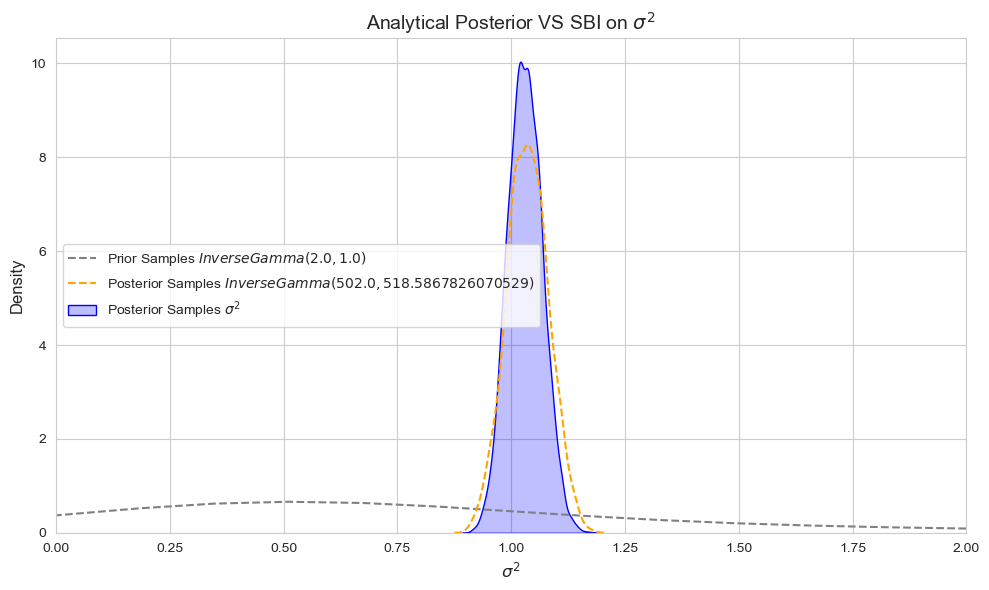

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 从样本中提取第二个维度的值
sigma2_samples = samples[:, 1].numpy()  # 提取样本的第二个维度（例如 $\sigma^2$）
theta_true_value = theta_true[0, 1].item() if torch.is_tensor(theta_true) else theta_true[0, 1]

num_samples = 1000  # 样本数量

# 设置 Prior 分布的参数
alpha_prior = 2.0  # 形状参数 α
beta_prior = 1.0   # 率参数 β

# 转换为逆伽马分布样本
prior_samples = 1 / np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=num_samples)  

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax,  label=f"Prior Samples $InverseGamma({alpha_prior}, {beta_prior})$", color="grey",linestyle="--")

# 转换为逆伽马分布样本
prior_samples = 1 / np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=num_samples)  

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax,  label=f"Posterior Samples $InverseGamma({alpha_poster}, {beta_poster})$", color="orange",linestyle="--")


# 使用采样数据绘制 Posterior 的 KDE 图
sns.kdeplot(sigma2_samples, ax=ax, fill=True, label=r"Posterior Samples $\sigma^2$", color="blue")

# 如果需要，可以添加真实值的垂直线
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\sigma^2$ = {theta_true_value}")

# 添加图例、标题和标签
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(0, 2)

# 显示图形
plt.tight_layout()
plt.show()


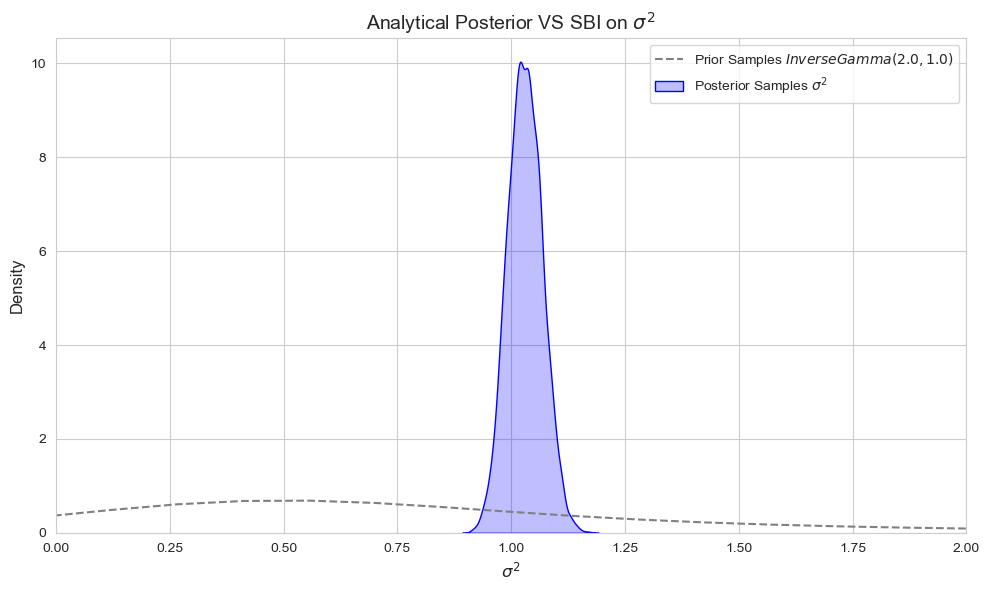

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 从样本中提取第二个维度的值
sigma2_samples = samples[:, 1].numpy()  # 提取样本的第二个维度（例如 $\sigma^2$）
theta_true_value = theta_true[0, 1].item() if torch.is_tensor(theta_true) else theta_true[0, 1]

num_samples = 1000  # 样本数量

# 设置 Prior 分布的参数
alpha_prior = 2.0  # 形状参数 α
beta_prior = 1.0   # 率参数 β

# 转换为逆伽马分布样本
prior_samples = 1 / np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=num_samples)  

# 使用采样数据绘制 Prior 的 KDE 图
sns.kdeplot(prior_samples, ax=ax,  label=f"Prior Samples $InverseGamma({alpha_prior}, {beta_prior})$", color="grey",linestyle="--")

# 使用采样数据绘制 Posterior 的 KDE 图
sns.kdeplot(sigma2_samples, ax=ax, fill=True, label=r"Posterior Samples $\sigma^2$", color="blue")

# 如果需要，可以添加真实值的垂直线
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\sigma^2$ = {theta_true_value}")

# 添加图例、标题和标签
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# 设置 x 轴范围
ax.set_xlim(0, 2)

# 显示图形
plt.tight_layout()
plt.show()


In [65]:
#posterior = inference.build_posterior(density_estimator)

In [66]:
#x_obs_np = x_obs.cpu().numpy() if x_obs.is_cuda else x_obs.numpy()


In [67]:
# import numpy as np
# from scipy.optimize import minimize
# from scipy.stats import multivariate_normal
# 
# def gaussian_approximation(log_posterior, grad_log_posterior, data, init_params):
#     """
#     通过 MAP 和 Fisher 信息矩阵进行 Gaussian Approximation。
#     
#     参数：
#     - log_posterior: 对数后验分布函数，接受参数 `params` 和数据 `data`
#     - grad_log_posterior: 对数后验分布的梯度函数
#     - data: 数据
#     - init_params: 初始参数值，用于优化
#     
#     返回：
#     - map_estimate: MAP 点（最大后验估计值）
#     - covariance: 协方差矩阵（Fisher 信息矩阵的逆）
#     - approx_distribution: scipy.stats.multivariate_normal 对象，表示高斯近似分布
#     """
#     # 1. 寻找 MAP 点（最大化对数后验）
#     def negative_log_posterior(params):
#         return -log_posterior(params, data)
# 
#     def negative_grad_log_posterior(params):
#         return -grad_log_posterior(params, data)
#     
#     result = minimize(
#         negative_log_posterior,
#         init_params,
#         jac=negative_grad_log_posterior,
#         method="BFGS"
#     )
#     
#     map_estimate = result.x  # MAP 点
#     hessian_inv = result.hess_inv  # Hessian 矩阵的逆（近似协方差矩阵）
#     
#     # 2. 使用 MAP 点和 Hessian 矩阵构建 Gaussian Approximation
#     covariance = hessian_inv  # Fisher 信息矩阵的逆
#     approx_distribution = multivariate_normal(mean=map_estimate, cov=covariance)
#     
#     return map_estimate, covariance, approx_distribution


In [68]:
# import numpy as np
# 
# def log_posterior(params, data):
#     """
#     计算对数后验分布。
#     参数：
#     - params: 参数数组，形状为 [mu, sigma]
#     - data: 观测数据
#     返回：
#     - 对数后验分布值
#     """
#     mu, sigma = params
#     std_dev = np.exp(sigma)  # 确保 exp(sigma) > 0
#     y = data
#     n = len(y)
# 
#     # 先验部分
#     log_prior_mu = -0.5 * mu**2  # mu 的先验
#     log_prior_sigma = -0.5 * sigma**2  # sigma 的先验
# 
#     # 似然部分
#     log_likelihood = -0.5 * np.sum((y - mu)**2) / std_dev**2 - n * sigma
# 
#     return log_prior_mu + log_prior_sigma + log_likelihood
# 
# 
# def grad_log_posterior(params, data):
#     """
#     计算对数后验分布的梯度。
#     参数：
#     - params: 参数数组，形状为 [mu, sigma]
#     - data: 观测数据
#     返回：
#     - 梯度值数组，形状为 [grad_mu, grad_sigma]
#     """
#     mu, sigma = params
#     std_dev = np.exp(sigma)  # 确保 exp(sigma) > 0
#     y = data
#     n = len(y)
# 
#     # 梯度计算
#     grad_mu = np.sum(y - mu) / std_dev**2 - mu  # mu 的梯度
#     grad_sigma = np.sum((y - mu)**2) / std_dev**2 - n - sigma  # sigma 的梯度
# 
#     return np.array([grad_mu, grad_sigma])


In [69]:
# data = x_obs_np
# 
# # 初始参数
# init_params = np.array([0.0, np.log(1.0)])  # 初始 mu 和 log(sigma)
# 
# # 调用 Gaussian Approximation
# map_estimate, covariance, approx_distribution = gaussian_approximation(
#     log_posterior, grad_log_posterior, data, init_params
# )
# 
# # 打印结果
# print("MAP 估计值:", map_estimate)
# print("协方差矩阵:\n", covariance)
# print("高斯近似分布的均值:", approx_distribution.mean)
# print("高斯近似分布的协方差:\n", approx_distribution.cov)

In [70]:
# import matplotlib.pyplot as plt
# 
# # 计算后验均值 μ'
# mu_post = 0.15414934
# 
# # 计算后验方差 σ_post^2
# sigma_post_sq = 0.28483513
# 
# # 计算标准差
# sigma_post = np.sqrt(sigma_post_sq)
# 
# # 生成 x 轴范围（基于 mu 和 3σ 范围）
# x = np.linspace(mu_post - 4 * sigma_post, mu_post + 4 * sigma_post, 500)
# 
# 
# # 计算正态分布的概率密度函数
# pdf = (1 / (np.sqrt(2 * np.pi) * sigma_post)) * np.exp(-0.5 * ((x - mu_post) / sigma_post) ** 2)
# 
# # 绘图
# plt.figure(figsize=(8, 5))
# plt.plot(x, pdf, label=f"Normal Distribution\n$\mu={mu_post}$, $\sigma^2={sigma_post_sq}$")
# plt.title("Normal Distribution")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.legend()
# plt.grid(True)
# plt.show()


In [71]:
# import seaborn as sns
# # pairplot 数据准备
# mu_samples = samples[:, 0].numpy()  # 提取样本的第一个维度（例如 $\mu$）
# theta_true = theta_true.numpy() if torch.is_tensor(theta_true) else theta_true
# 
# # 创建单个绘图
# fig, ax = plt.subplots(figsize=(8, 6))
# pdf1 = (1 / (np.sqrt(2 * np.pi) * 1)) * np.exp(-0.5 * ((x - 0) / 1) ** 2)
# # 绘制 Posterior Samples 的 KDE 图
# sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$")
# 
# # 绘制正态分布
# ax.plot(x, pdf, label=f"Guassian Approximation", color="red", linestyle="--")
# pdf1 = (1 / (np.sqrt(2 * np.pi) * 1)) * np.exp(-0.5 * ((x - 0) / 1) ** 2)
# plt.plot(x, pdf1, label=f"Prior Distribution\n$\mu={0}$, $\sigma^2={1}$",color="grey")
# # 添加图例、标题和标签
# ax.set_title("Gaussian Approximation VS SBI on miu = 0")
# ax.set_xlabel(r"$\mu$")
# ax.set_ylabel("Density")
# ax.legend()
# ax.grid(True)
# 
# # 显示图形
# plt.tight_layout()
# plt.show()


In [72]:
# import matplotlib.pyplot as plt
# 
# # 计算后验均值 μ'
# mu_post = 0.16489241
# 
# # 计算后验方差 σ_post^2
# sigma_post_sq = 0.20329807
# 
# # 计算标准差
# sigma_post = np.sqrt(sigma_post_sq)
# 
# # 生成 x 轴范围（基于 mu 和 3σ 范围）
# x = np.linspace(mu_post - 4 * sigma_post, mu_post + 4 * sigma_post, 500)
# 
# 
# # 计算正态分布的概率密度函数
# pdf = (1 / (np.sqrt(2 * np.pi) * sigma_post)) * np.exp(-0.5 * ((x - mu_post) / sigma_post) ** 2)
# pdf1 = (1 / (np.sqrt(2 * np.pi) * 1)) * np.exp(-0.5 * ((x - 0) / 1) ** 2)
# # 绘图
# plt.figure(figsize=(8, 5))
# plt.plot(x, pdf, label=f"Normal Distribution\n$\mu={mu_post}$, $\sigma^2={sigma_post_sq}$")
# plt.plot(x, pdf1, label=f"Prior Distribution\n$\mu={0}$, $\sigma^2={1}$")
# plt.title("Normal Distribution")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.legend()
# plt.grid(True)
# plt.show()


In [73]:
# import seaborn as sns
# # pairplot 数据准备
# mu_samples = samples[:, 1].numpy()  # 提取样本的第一个维度（例如 $\mu$）
# theta_true = theta_true.numpy() if torch.is_tensor(theta_true) else theta_true
# 
# # 创建单个绘图
# fig, ax = plt.subplots(figsize=(8, 6))
# 
# # 绘制 Posterior Samples 的 KDE 图
# sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\log(\sigma^2)$")
# 
# # 绘制正态分布
# ax.plot(x, pdf, label=f"Guassian Approximation", color="red", linestyle="--")
# plt.plot(x, pdf1, label=f"Prior Distribution\n$\mu={0}$, $\sigma^2={1}$")
# # 添加图例、标题和标签
# ax.set_title("Gaussian Approximation VS SBI on $\log(\sigma^2)= 0$ ")
# ax.set_xlabel(r"$\mu$")
# ax.set_ylabel("Density")
# ax.legend()
# ax.grid(True)
# 
# # 显示图形
# plt.tight_layout()
# plt.show()
